# Selforganizing Systems Exercise 3 (Coding)
Group f1: Yana Sakhnovych - 11777748 , Alexander Sifel - 01427034, Christian Obereder - 11704936

inhaltsverzeichniss
    
## 1 Preamble
The exercise description frequently mentions how the coding exercise is about visualizing SOMs / adding a new visualization to the existing ones in the template. Unless we misunderstood some important apsect of mnemonic SOMs, this does not seem to fully apply for our task. Instead of taking a trained SOM and visualizing it in some special way,  our task appeares to rather be adapting the training algorithm of a SOM in such a way that the provided standard visualization display a mnemonic SOM :

*Mnemonic SOM: Reading a black/white silhouette image to determine the shape of the SOM,
computing a look-up table for shortest distance between two units for the training process,
and mapping it into a regular SOM data structure to support the standard visualizations*

Therefore, we adapted the standard SOM training algorithm provided by MiniSom by adding the option to train a mnemonic SOM. As a result of this, parts of our code are in the MiniSom python file minisom.py, although we will show excerpts of that code in this report for the sake of presentation.
Apart from MiniSom as codebase, we used [1] as a reference for how to implement mnemonic SOM. We also use images that are very similar to the ones used in [1] (Figure-Person, Austria) for comparrison.



[1] Mayer, Rudolf, Dieter Merkl, and Andreas Rauber. Mnemonic SOMs: Recognizable shapes for self-organizing maps. na, 2005.

## 2 Implementation
#### Imports

In [ ]:
# Read data from Java SOMToolbox
from SOMToolBox_Parse import SOMToolBox_Parse
from minisom import MiniSom
from somtoolbox import SOMToolbox
import pickle
import collections
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os.path
from os import path

### 2.1 Reading of black-white sillhouette from an image and generating lookup-tables for shortest distance between units
For determening the shape of the mnemonic SOM, we use black-white images, with white representing positions that have a node and black representing positions that do not. This image is converted to a numpy array with ones representing white and zero representing black. This representation was chose in order to be able to easily multiply this shape-matrix with the randomly initialized weight matrix of the SOM during the SOM training, resulting in a weight matrix where the weights for all positions that should not have a node is a vector of zeros. 

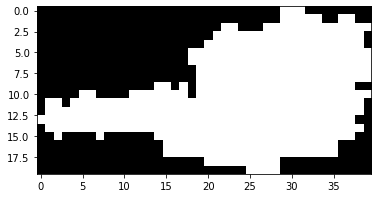

In [8]:
#takes a black-white image and returns a np-array with 1 for white pixels and 0 for black pixels
def read_bw_silhouette(filename):
    img = Image.open(filename).convert('L')
    return np.array(img) / 255

sample_img = read_bw_silhouette('austria.png')
plt.imshow(sample_img,cmap='gray', vmin = 0, vmax = 1)

For mnemonic SOMs, it is difficult to use any of the standard neighborhood and distance functions, as neighborhood is no longer dependend on only the coordinates of two positions, but rather on whether or not there is a path between those positions and how long that path is[1]. Therefore, for every possible position (j,k) in the provided image-matrix, we create an adjacency-matrix where the value of some position in that matrix(l,k) is an adapted manhattan-distance between (j,k) and (l,k). This adapted manhattan-distance only considers positions with a value of one to be traversable positions. If the value of (j,k) itself is zero, a matrix of zeros is returned.
This effectively means that for every (j,k), we calculate a matrix with the shortest path to all other positions in the matrix.

At the end, all non-zero values v in the matrices are replaced 1/v. The matrices resulting from this procedure can be used as neighborhood functiions in the SOM training algorithm, as they take the shape of the sillhouette into account.

In [12]:
# Given a matrix, computes manhatten distance to each other point in the matrix, avoiding "walls"
# grid: A 2d matrix
# start: the position in the matrix from where to calculate manhatten distance to all other positions
# wall: a value that that can not be traversed and where the distance will always be 0.
def get_paths_for_point(grid, start, wall):
    max_x, max_y = grid.shape[0],grid.shape[1]
    result = np.zeros((grid.shape[0],grid.shape[1]))
    #if start-point is a 0, distances to all other nodes will be 0
    if grid[start] == 0:
        return result
    queue = collections.deque([[start]])
    seen = set([start])
    i = 1
    result[start] = i
    while queue:
        path = queue.popleft()
        x, y = path[-1]
        i = result[x, y]
        for x2, y2 in ((x+1,y), (x-1,y), (x,y+1), (x,y-1)):
            if 0 <= x2 < max_x and 0 <= y2 < max_y and grid[x2][y2] != wall and (x2, y2) not in seen:
                queue.append(path + [(x2, y2)])
                seen.add((x2, y2))
                result[x2,y2] = i + 1
    return result

#convert image array to a dictionary, mapping each point (j,k) to its adjacency matrix
def image_array_to_adjacency_mapping(img_np):
    adjacency_dict = {}

    for i in range(img_np.shape[0]):
        for j in range(img_np.shape[1]):
            cur_result_matrix = get_paths_for_point(img_np, (i,j), 0.0)
            cur_result_matrix[np.nonzero(cur_result_matrix)] = 1 / cur_result_matrix[np.nonzero(cur_result_matrix)]
            adjacency_dict[i, j] = cur_result_matrix
    return adjacency_dict

To visualize what is described above, an example is shown for an image with the sillhouette of austria in 40x20 and the adjacency values of the position (19,9) (shown in red) :

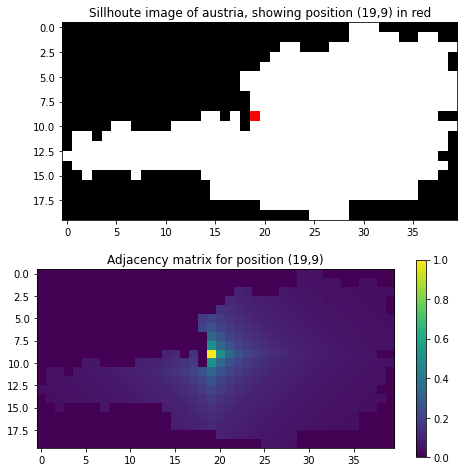

In [27]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))

red_dot_image = np.array(Image.open('austria.png'))
red_dot_image[9,19] = [255,0,0]
ax1.imshow(red_dot_image)
ax1.set_title("Sillhoute image of austria, showing position (19,9) in red")

adjacency_dict = image_array_to_adjacency_mapping(sample_img)
im = ax2.imshow(adjacency_dict[9,19])
cbar = plt.colorbar(im)
ax2.set_title("Adjacency matrix for position (19,9)")
plt.show()

### 2.2 Adapting of the MiniSom implementation to support mnemonic SOMs
As mentioned in Section 1, we had to make changes to the SOM training algorithm provided by the MiniSom library. We will show excerpts of the code there, particularly of the parts that we had to adapt, as pasting the whole code here would be confusing. The code in its entirety can be viewed in minisom.py .

* Added the optional parameters lookuptable and mnemonic_shape to the constructor of the MiniSom class. These are supposed to be filled with the map of adjacency-matrices and the numpy array of the read image respectively.
* For the available options for the neighborhood_functions, the option 'lookuptable' was added, which uses the map provided with the lookuptable parameter to compute the neighborhood for a position. For the available options for the activation_distance function, the option 'manhattan_mnemonic' was added, which uses the sillhouette provided with the mnemonic_shape parameter to compute the winner in a round of training without taking empty positions into account.
* For the intialization of the MiniSom class, the following changes were made, using the parameters described above. Basically, the new parameters are read, mnemonic shape is read once normally and once with 0 mapped to infinity (which will be used in the activation function). Then, the random weights for the training process are initialized. After intializiation, the weight matrix is multiplied the mnemonic_shape matrix (which is expanded to be of the same dimension of the weight matrix), resulting in a weight matrix where the weight-vectors for positions where there should not be a node consists of only zeros.
    Technically speaking, in our implementation all positions have a node, it is just for all positions where we do not want a node, the weights of that node are set to all zeros (and these nodes are never considered as candidate for determening a winner and never have their weights updated, as will be shown further below).

``` python
    self._lookuptable = lookuptable
    self._mnemonic_shape = mnemonic_shape.copy()
    self._mnemonic_shape_inf = mnemonic_shape.copy()
    self._mnemonic_shape_inf[where(self._mnemonic_shape_inf == 0)] = inf

    self._weights = self._random_generator.rand(x, y, input_len)*2-1
    self._weights /= linalg.norm(self._weights, axis=-1, keepdims=True)
    if (self._mnemonic_shape is not None):
        self._weights *= self._mnemonic_shape.repeat(self._weights.shape[2]).reshape(*self._mnemonic_shape.shape, -1)

```
    
* Below, the functions for determening a winner used by MiniSom are shown. In this block, only the function _manhattan_distance_mnemonic was written by us. It can be seen that MiniSom uses the function stored in activasion_distance (for example _manhatten_distance) to produce a matrix with each units activation. It then takes the  position of the smallest value in the matrix, which is the winner. We adapted the existing _manhattan_distance function by multiplying it with _mnemonic_shape_inf, which, as mentioned above, is the matrix of the sillhouette but with zeros replace by infinity. The resulting activation function is one where the distance of any position outside of the sillhoutte / without a node is always infinity. This means that such a position will never be determined as the winner.
``` python 
    def _activate(self, x):
        """Updates matrix activation_map, in this matrix
           the element i,j is the response of the neuron i,j to x."""
        self._activation_map = self._activation_distance(x, self._weights)

    def activate(self, x):
        """Returns the activation map to x."""
        self._activate(x)
        return self._activation_map

    def winner(self, x):
        """Computes the coordinates of the winning neuron for the sample x."""
        self._activate(x)
        return unravel_index(self._activation_map.argmin(),
                             self._activation_map.shape)

    def _manhattan_distance(self, x, w):
        return linalg.norm(subtract(x, w), ord=1, axis=-1)

    def _manhattan_distance_mnemonic(self, x, w):
        return linalg.norm(subtract(x, w), ord=1, axis=-1) * self._mnemonic_shape_inf
```

* Lastly, we adapted the update function, which MiniSom uses to update weights per iteration. Here, the neighborhood function is calculated and then weights are updated using the numpy's einsum method. Normally, the neighborhood functioon (such as _gaussian which can be seen below) calculates the neighborhood-matrix based on coordinates. However, using our _lookuptable_distance method, we define the neighborhood-matrix as described in 2.1, meaning a neighborhood-matrix where the values for any empty / out-of-sillhouette positions are 0 and and the sillhouette is generally taken into account.
``` python
    def update(self, x, win, t, max_iteration):
        """Updates the weights of the neurons.

        Parameters
        ----------
        x : np.array
            Current pattern to learn.
        win : tuple
            Position of the winning neuron for x (array or tuple).
        t : int
            Iteration index
        max_iteration : int
            Maximum number of training itarations.
        """

        eta = self._decay_function(self._learning_rate, t, max_iteration)
        # sigma and learning rate decrease with the same rule
        sig = self._decay_function(self._sigma, t, max_iteration)
        # improves the performances
        g = self.neighborhood(win, sig)*eta
        # w_new = eta * neighborhood_function * (x-w)
        self._weights += einsum('ij, ijk->ijk', g, x-self._weights)

    def _gaussian(self, c, sigma):
        """Returns a Gaussian centered in c."""
        d = 2*sigma*sigma
        ax = exp(-power(self._xx-self._xx.T[c], 2)/d)
        ay = exp(-power(self._yy-self._yy.T[c], 2)/d)
        return (ax * ay).T  # the external product gives a matrix

    def _lookuptable_distance(self, c, sigma):
        d = 2 * sigma * sigma
        return self._lookuptable[(c[0], c[1])] / d
```

### 2.3 Testing implementation with an austria-sillhouette and iris dataset
As an initial test of our implementation, we train a mnemonic SOM with the adapted MiniSom code, using the iris dataset and an image of austria as the sillhouette. We then roughly compare the result to austria-iris mnemonic map shown in [1]. It must be noted however that different visualization tools were used for these SOMs.

In [71]:
#training and visualization put into a function to make the notebook less bloated

def train_and_display_som(data,  max_x, max_y, learning_rate = 1, sigma = 1, iterations = 1000, 
                          neighborhood_function = None, activation_distance= None , lookuptable = None,
                          mnemonic_shape = None):
    som = MiniSom(max_x, max_y, data['vec_dim'], sigma=sigma, learning_rate=learning_rate, neighborhood_function = 'lookup',
                  activation_distance='manhattan_mnemonic' , lookuptable = lookuptable,
                  mnemonic_shape = mnemonic_shape)
    som.train(data['arr'], iterations)
    sm = SOMToolbox(weights=som._weights.reshape(-1, data['vec_dim']), 
                    n=max_y, m=max_x, dimension=data['vec_dim'], input_data=data['arr'])
    return sm

In [66]:
#train mnemonic SOM on iris data, result can be compared to the 2005 paper 
#(https://publik.tuwien.ac.at/files/pub-inf_2979.pdf), Figure 3

#load iris data
idata = SOMToolBox_Parse("datasets\\iris\\iris.vec").read_weight_file()
weights = SOMToolBox_Parse("datasets\\iris\\iris.wgt.gz").read_weight_file()
classes = SOMToolBox_Parse("datasets\\iris\\iris.cls").read_weight_file()

#load sillhouette image and transform to numpy array:
img_arr = read_bw_silhouette('austria.png')
print(img_arr.shape)

#create adjacancy dictionary or load if already exists (pickled):
adjacency_dict = {}
if (path.exists("adjacency_austria.pickle")):
    with open('adjacency_austria.pickle', 'rb') as handle:
        adjacency_dict = pickle.load(handle)
else:
    adjacency_dict = image_array_to_adjacency_mapping(img_arr)
    with open("adjacency_austria.pickle", "wb") as output_file:
        pickle.dump(adjacency_dict, output_file) 

sm = train_and_display_som(idata, 20, 40, sigma=2, learning_rate=1, neighborhood_function = 'lookup',
              activation_distance='manhattan_mnemonic' , lookuptable = adjacency_dict, mnemonic_shape = img_arr)
sm._mainview

(20, 40)


Column
    [0] Column
        [0] Column
            [0] Row(margin=5, width=700)
                [0] StaticText(value='<b></b>')
                [1] Select(options=OrderedDict([('Component P...]), value=0)
                [2] Select(options=OrderedDict([('PiYG', ...]), value='jet')
                [3] Button(name='↩')
                [4] Button(name='↪')
                [5] Checkbox(name='interpolation')
        [1] Row
            [0] Column
                [0] HoloViews(DynamicMap)
            [1] Row
                [0] Column
                    [0] Column(margin=5, name='Component Planes', width=300)
                        [0] StaticText(value='<b>Component Planes</b>')
                        [1] IntSlider(end=3, name='Component')
                    [1] Str(str)
    [1] Column
        [0] Row()

Showing the resulting SOM visualization from the above cell, as to our knowledge the generated visualization get lost when the notebook is closed an reopened. SOMToolbox parameters for generating our visualization: Method = Clustering, Color = jet, Approach = KMeans, Linkage type = single, Clusters = 4.

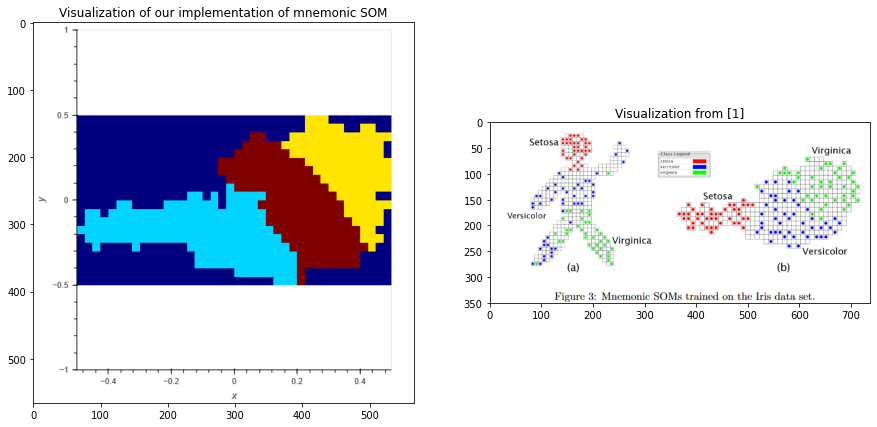

In [37]:
img_self = Image.open("experiment_results/austra_iris_clustering_jet_kmeans_4components.png")
img_paper = Image.open("experiment_results/iris_austria_mnemonic_soms_recoglizable_shapes_for_self-organizing_maps.png")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

ax1.imshow(img_self)
ax1.set_title("Visualization of our implementation of mnemonic SOM")

ax2.imshow(img_paper)
ax2.set_title("Visualization from [1]")
plt.show()

### 3 Evaluation (Work in progress)

In [ ]:
#load 10clusters data
clusters_data = SOMToolBox_Parse("datasets\\10clusters\\10clusters.vec").read_weight_file()
clusters_classes = SOMToolBox_Parse("datasets\\10clusters\\10clusters.cls").read_weight_file()
clusters_weight = SOMToolBox_Parse("datasets\\10clusters\\10clusters.wgt").read_weight_file()

#load chainlink data
chain_data = SOMToolBox_Parse("datasets\\chainlink\\chainlink.vec").read_weight_file()
chain_classes = SOMToolBox_Parse("datasets\\chainlink\\chainlink.cls").read_weight_file()
chain_weight = SOMToolBox_Parse("datasets\\chainlink\\chainlink.wgt").read_weight_file()

Here we train a small (40x20) SOM in the shape of austria and a large SOM (100x60) in the shape of a figure-person using the 10clusters dataset:

In [68]:
#load sillhouette image and transform to numpy array:
img_arr = read_bw_silhouette('austria.png')
print(img_arr.shape)

#create adjacancy dictionary or load if already exists (pickled):
adjacency_dict = {}
if (path.exists("adjacency_austria.pickle")):
    with open('adjacency_austria.pickle', 'rb') as handle:
        adjacency_dict = pickle.load(handle)
else:
    adjacency_dict = image_array_to_adjacency_mapping(img_arr)
    with open("adjacency_austria.pickle", "wb") as output_file:
        pickle.dump(adjacency_dict, output_file) 
        


sm = train_and_display_som(clusters_data, 20, 40, sigma=1.2, learning_rate=1, neighborhood_function = 'lookup',
              activation_distance='manhattan_mnemonic' , lookuptable = adjacency_dict, mnemonic_shape = img_arr)
sm._mainview

(20, 40)


Column
    [0] Column
        [0] Column
            [0] Row(margin=5, width=700)
                [0] StaticText(value='<b></b>')
                [1] Select(options=OrderedDict([('Component P...]), value=0)
                [2] Select(options=OrderedDict([('PiYG', ...]), value='jet')
                [3] Button(name='↩')
                [4] Button(name='↪')
                [5] Checkbox(name='interpolation')
        [1] Row
            [0] Column
                [0] HoloViews(DynamicMap)
            [1] Row
                [0] Column
                    [0] Column(margin=5, name='Component Planes', width=300)
                        [0] StaticText(value='<b>Component Planes</b>')
                        [1] IntSlider(end=9, name='Component')
                    [1] Str(str)
    [1] Column
        [0] Row()

In [72]:
#load sillhouette image and transform to numpy array:
img_arr_fig = read_bw_silhouette('figure_large.png')
print(img_arr_fig.shape)

#create adjacancy dictionary or load if already exists (pickled):
adjacency_dict = {}
if (path.exists("adjacency_figure_large.pickle")):
    with open('adjacency_figure_large.pickle', 'rb') as handle:
        adjacency_dict = pickle.load(handle)
else:
    adjacency_dict = image_array_to_adjacency_mapping(img_arr_fig)
    with open("adjacency_figure_large.pickle", "wb") as output_file:
        pickle.dump(adjacency_dict, output_file)


sm = train_and_display_som(clusters_data, 60, 100, sigma=1, learning_rate=1, neighborhood_function = 'lookup',
              activation_distance='manhattan_mnemonic' , lookuptable = adjacency_dict, mnemonic_shape = img_arr_fig)
sm._mainview

(60, 100)


Column
    [0] Column
        [0] Column
            [0] Row(margin=5, width=700)
                [0] StaticText(value='<b></b>')
                [1] Select(options=OrderedDict([('Component P...]), value=0)
                [2] Select(options=OrderedDict([('PiYG', ...]), value='jet')
                [3] Button(name='↩')
                [4] Button(name='↪')
                [5] Checkbox(name='interpolation')
        [1] Row
            [0] Column
                [0] HoloViews(DynamicMap)
            [1] Row
                [0] Column
                    [0] Column(margin=5, name='Component Planes', width=300)
                        [0] StaticText(value='<b>Component Planes</b>')
                        [1] IntSlider(end=9, name='Component')
                    [1] Str(str)
    [1] Column
        [0] Row()

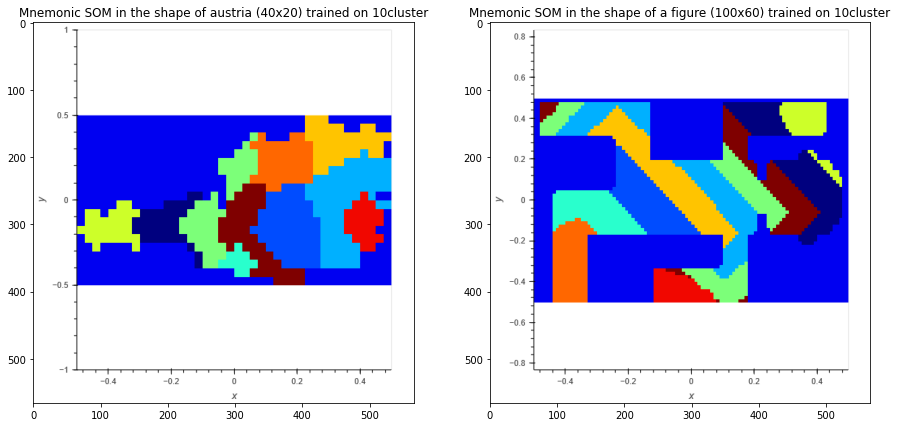

In [58]:
som_small = Image.open("experiment_results/austria_chainlink_clustering_jet_kmeans_11components.png")
som_large = Image.open("experiment_results/figure_chainlink_clustering_jet_kmeans_11components.png")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

ax1.imshow(som_small)
ax1.set_title("Mnemonic SOM in the shape of austria (40x20) trained on 10cluster")

ax2.imshow(som_large)
ax2.set_title("Mnemonic SOM in the shape of a figure (100x60) trained on 10cluster")
plt.show()

#### Normal SOM trained in SOMToolbox and imported

In [6]:
# SOM trained on cluster dataset from SOMToolbox page

sm = SOMToolbox(weights=clusters_weight['arr'],m=clusters_weight['ydim'],n=clusters_weight['xdim'],
                dimension=clusters_weight['vec_dim'], input_data=clusters_data['arr'],
               classes=clusters_classes['arr'], component_names=clusters_classes['classes_names'])
sm._mainview

Column
    [0] Column
        [0] Column
            [0] Row(margin=5, width=700)
                [0] StaticText(value='<b></b>')
                [1] Select(options=OrderedDict([('Component P...]), value=0)
                [2] Select(options=OrderedDict([('PiYG', ...]), value='jet')
                [3] Button(name='↩')
                [4] Button(name='↪')
                [5] Checkbox(name='interpolation')
        [1] Row
            [0] Column
                [0] HoloViews(DynamicMap)
            [1] Row
                [0] Column
                    [0] Column(margin=5, name='Component Planes', width=300)
                        [0] StaticText(value='<b>Component Planes</b>')
                        [1] IntSlider(end=9, name='1')
                    [1] Str(str)
    [1] Column
        [0] Row()